In [2]:
# Import necessary libraries
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
# Define paths
dataset_dir = r'C:\Users\japer\Desktop\Brain_Cancer\Dataset'
healthy_dir = os.path.join(dataset_dir, 'healthy')
tumor_dir = os.path.join(dataset_dir, 'tumor')

# Temporary directories for splitting data
split_base_dir = os.path.join(dataset_dir, 'split_data')
train_dir = os.path.join(split_base_dir, 'train')
val_dir = os.path.join(split_base_dir, 'val')
test_dir = os.path.join(split_base_dir, 'test')

# Function to split data into train/val/test
def split_data(source_dir, train_dest, val_dest, test_dest, test_size=0.2, val_size=0.2):
    images = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)
    
    # Helper to copy files
    for image_path in train_images:
        shutil.copy(image_path, train_dest)
    for image_path in val_images:
        shutil.copy(image_path, val_dest)
    for image_path in test_images:
        shutil.copy(image_path, test_dest)

# Ensure directories exist and split data
if not os.path.exists(split_base_dir):
    os.makedirs(os.path.join(train_dir, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'tumor'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'tumor'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'tumor'), exist_ok=True)

    # Split data for healthy images
    split_data(
        source_dir=healthy_dir,
        train_dest=os.path.join(train_dir, 'healthy'),
        val_dest=os.path.join(val_dir, 'healthy'),
        test_dest=os.path.join(test_dir, 'healthy')
    )

    # Split data for tumor images
    split_data(
        source_dir=tumor_dir,
        train_dest=os.path.join(train_dir, 'tumor'),
        val_dest=os.path.join(val_dir, 'tumor'),
        test_dest=os.path.join(test_dir, 'tumor')
    )

    print("Data split into train, validation, and test sets.")

# Image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Output class indices for reference
print("Class Indices:", train_generator.class_indices)



Found 494 images belonging to 2 classes.
Found 125 images belonging to 2 classes.
Found 156 images belonging to 2 classes.
Class Indices: {'healthy': 0, 'tumor': 1}


In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: healthy and tumor

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 201s 13s/step - accuracy: 0.6091 - loss: 0.7995 - val_accuracy: 0.9271 - val_loss: 0.2936
Epoch 2/5
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2:47 12s/step - accuracy: 0.7812 - loss: 0.5734

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7812 - loss: 0.5734 - val_accuracy: 0.9583 - val_loss: 0.1887
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 183s 12s/step - accuracy: 0.8533 - loss: 0.3571 - val_accuracy: 0.9479 - val_loss: 0.2259
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.7812 - loss: 0.6397 - val_accuracy: 0.9479 - val_loss: 0.2055
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 209s 14s/step - accuracy: 0.8277 - loss: 0.4031 - val_accuracy: 0.9375 - val_loss: 0.2084
5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 12s/step - accuracy: 0.9004 - loss: 0.2405
Test Loss: 0.29538479447364807
Test Accuracy: 0.8782051205635071


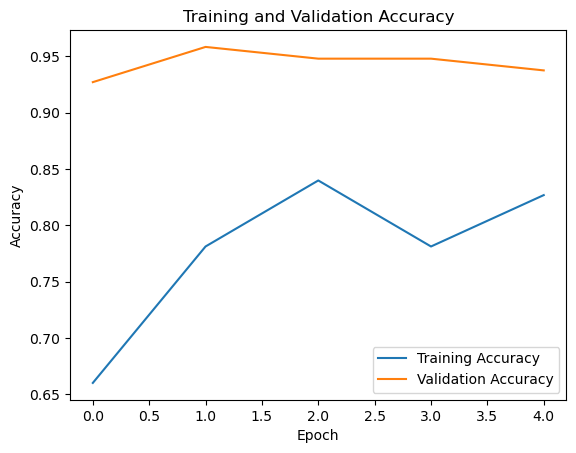

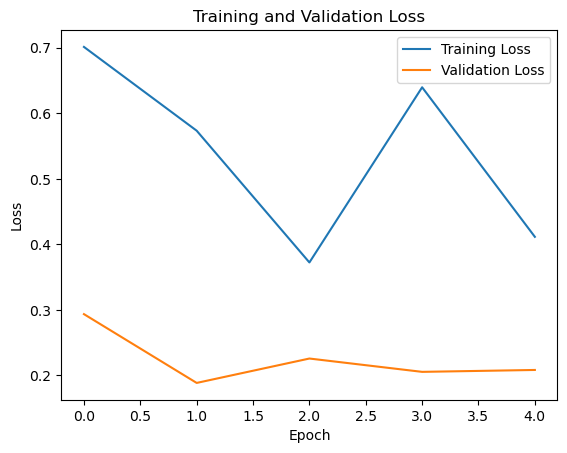

In [ ]:
# Plot training and validation accuracy/loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
model.save("brain_cancer_model.h5")
print("Model saved as brain_cancer_model.h5")


Model saved as brain_cancer_model.h5
